<a href="https://colab.research.google.com/github/Romulol-B/Image_Matching_2025/blob/main/loftr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilizando Loftr para match de angulo , e recortar a area com maior numero de matches.

#Imports e download do dataset

In [1]:
!pip install kaggle -q

In [2]:
!pip install gdown -q

In [3]:
!pip install --upgrade gdown

import gdown
# a file
url = 'https://drive.google.com/uc?id=1Hm6HFfeckASmlHUA0cCDgQIoQc5Vrm7S'
output = "kaggle.json"
gdown.download(url, quiet=True,output=output)

'kaggle.json'

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
import torch
import cv2
import numpy as np
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
import shutil
from PIL import Image
import torchvision
import random
from torchvision import transforms
import math

In [ ]:
!kaggle competitions download -c image-matching-challenge-2025
!unzip -q image-matching-challenge-2025

 20% 0.98G/4.84G [00:22<01:39, 41.9MB/s]

# Normalizando e augmentando os dados.

In [ ]:
brightness=(0.98, 1.02)
gamma=(0.5, 1.1)
gaussian_std=(0,0.02)
resolution = (256 , 256)

In [ ]:
def delete_np(y,indice):
  y = np.concatenate((y[:indice],y[indice+1:]))
  return y

In [ ]:
def data_augmentation(img, brightness=(0.98, 1.02), gamma=(0.5, 1.1), gaussian_std=(0,0.02)):
  img = (img + 1) / 2  # Map from [-1, 1] to [0, 1] if normalized

  gamma_val = random.uniform(gamma[0], gamma[1])
  img = transforms.functional.adjust_gamma(img, gamma_val)

  brightness_val = random.uniform(brightness[0], brightness[1])
  img = transforms.functional.adjust_brightness(img, brightness_val)
  # Gaussian noise (if needed)
  noise = torch.randn_like(img) * random.uniform(gaussian_std[0],gaussian_std[1])
  img = img + noise

  # Clamp and re-normalize to [-1, 1]
  img = torch.clamp(img, 0, 1)  # First clamp to [0, 1]
  img = img * 2 - 1  # Map back to [-1, 1]

  return img

In [ ]:
transform = transforms.Compose([
    transforms.Resize(resolution),
    transforms.ToTensor(),  # [0, 1]
    transforms.Normalize(mean=[0.5], std=[0.5]),  # [-1, 1]
    transforms.Grayscale(),
    transforms.RandomApply(
        [transforms.Lambda(lambda x: data_augmentation(x))],
       p=0.5  # 50% chance to apply
    ),
])
kaggle_data = torchvision.datasets.ImageFolder('/content/train/',transform=transform)
data_loader = torch.utils.data.DataLoader(kaggle_data, batch_size=1)

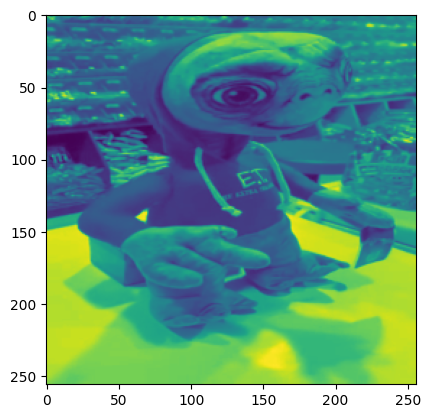

In [ ]:

img, label = kaggle_data[6]
plt.imshow(img.permute(1, 2, 0))

In [ ]:
img.shape

torch.Size([1, 256, 256])

In [ ]:
img0_raw = img.flatten(start_dim=0,end_dim=1)
img0_raw.shape

torch.Size([256, 256])

In [ ]:
kaggle_data.classes

['ETs',
 'amy_gardens',
 'fbk_vineyard',
 'imc2023_haiper',
 'imc2023_heritage',
 'imc2023_theather_imc2024_church',
 'imc2024_dioscuri_baalshamin',
 'imc2024_lizard_pond',
 'pt_brandenburg_british_buckingham',
 'pt_piazzasanmarco_grandplace',
 'pt_sacrecoeur_trevi_tajmahal',
 'pt_stpeters_stpauls',
 'stairs']

#loftr import e config

In [ ]:
# Configure environment and grab LoFTR code.
!rm -rf sample_data
!pip install torch einops yacs kornia
!git clone https://github.com/zju3dv/LoFTR --depth 1
!mv LoFTR/* . && rm -rf LoFTR

# Download pretrained weights
!mkdir weights
%cd weights/
!gdown --id 1w1Qhea3WLRMS81Vod_k5rxS_GNRgIi-O  # indoor-ds
!gdown --id 1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY # outdoor-ds
%cd ..

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 84.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
   

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.cm as cm

from src.utils.plotting import make_matching_figure
from src.loftr import LoFTR, default_cfg

In [ ]:
matcher = LoFTR(config=default_cfg)
image_type='outdoor'
if image_type == 'indoor':
  matcher.load_state_dict(torch.load("weights/indoor_ds.ckpt")['state_dict'])
elif image_type == 'outdoor':
  matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])
else:
  raise ValueError("Wrong image_type is given.")
matcher = matcher.eval().cpu()

#Funções Basicas

In [ ]:
def dual_matching(img0_raw ,img01_raw,confi=0.15,device='cpu',matcher=matcher):

  img0_raw = img0_raw.flatten(start_dim=0,end_dim=1)
  img01_raw = img01_raw.flatten(start_dim=0,end_dim=1)

  # colocando na resolucao 1,1,256,256
  img0 = img0_raw[None,None,:,:]
  assert img0.shape ==(1,1,resolution[0],resolution[1])
  img01 = img01_raw[None,None,:,:]
  assert img01.shape ==(1,1,resolution[0],resolution[1])

  batch = {'image0': img0.to(device), 'image1': img01.to(device)}

  # Inference with LoFTR and get prediction
  with torch.no_grad():
    matcher(batch)
  mkpts0 = batch['mkpts0_f'].cpu().numpy()
  mkpts1  = batch['mkpts1_f'].cpu().numpy()
  mconf = batch['mconf'].cpu().numpy()
  i = 0
  mask = mconf >= confi
  mkpts0 = mkpts0[mask]
  mkpts1 = mkpts1[mask]
  mconf = mconf[mask]
  angs= []
  for i in range(len(mconf)):
    angs.append(math.atan((mkpts1[i]-mkpts0[i])[0].item()*(mkpts1[i]-mkpts0[i])[1].item()) )
  return np.array(mkpts0), np.array(mkpts1), np.array(mconf) ,np.array(angs)

In [ ]:
def draw_points(img0_raw, img01_raw, mkpts0, mkpts1,mconf):
  img0_raw = img0_raw.flatten(start_dim=0,end_dim=1)
  img01_raw = img01_raw.flatten(start_dim=0,end_dim=1)

  color = cm.jet(mconf, alpha=0.7)
  text = [
      'LoFTR',
      'Matches: {}'.format(len(mkpts0)),
  ]
  fig = make_matching_figure(img0_raw, img01_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text)
  # A high-res PDF will also be downloaded automatically.
  #make_matching_figure(img0_raw, img01_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text, path="LoFTR-colab-demo.pdf")

In [ ]:
def conf_sum(z,exp =3):
  return sum(np.power(np.array(z),exp))


In [ ]:
def rotation_matcher(img0,img01,rotation_rate =45):
  img01_raw =img01
  highst_conf = 0
  angle_best = 0
  for i in range(int(360/rotation_rate)):

    img01=torchvision.transforms.functional.rotate(img01_raw,angle= i*rotation_rate)
    p1, p2, conf, angs = dual_matching(img0,img01)
    #draw_points(img0,img01, p1, p2, conf)
    conf_total = conf_sum(conf)

    if highst_conf < conf_total:
      highst_conf = conf_total
      angle_best = i*rotation_rate

  img01=torchvision.transforms.functional.rotate(img01_raw,angle=angle_best)
  p1, p2, conf, angs =dual_matching(img0,img01)

  #draw_points(img0,img01, p1, p2, conf)
  return p1, p2, conf,angle_best ,highst_conf

In [ ]:
#ang_01 = torchvision.transforms.functional.rotate(img01,angle_best)
#p1, p2, conf, angs =dual_matching(img0,ang_01)
#draw_points(img0,ang_01,p1,p2,conf)

In [ ]:
#p1, p2, conf, angs =dual_matching(img0,img01)
#draw_points(img0,img01,p1,p2,conf)

In [ ]:
def density_f(pontos, conf):
  i = len(pontos)
  for p in range(len(pontos)):
    if conf[p] >0.75:
      pontos= np.insert(pontos,i,pontos[p],axis=0)
      i+=1
  return(pontos)

In [ ]:
def mult_matcher_square(img_group):
  n = len(img_group)
  matrix = [[None for _ in range(n)] for _ in range(n)]
  matrix_conf = [[None for _ in range(n)] for _ in range(n)]
  for i in range(n):
    for j in range(i + 1, n):
      p1, p2, conf, ang = dual_matching(img_group[i], img_group[j])
      matrix[i][j] = [p1, p2, conf, ang]
      matrix[j][i] = [p2, p1, conf, ang*-1]
      matrix_conf[j][i] = conf_sum(conf)
      matrix_conf[i][j] = conf_sum(conf)
      print(f"{i},{j}")

  return matrix,matrix_conf


In [ ]:
def mult_matcher_square_access(triangular_matrix,i,j):
  """sendo I < J   """
  matchers = triangular_matrix[i]
  points = matchers[j-i-1]
  return points

In [ ]:
def amostra(n):
  amostra =[]
  for i in range(n):
    img,_ = kaggle_data[-i-600]
    amostra.append(img)
  return amostra

#Crop de area densa usando DBSCAN

In [ ]:
def mult_matcher_density(matrix,i,n_imgs):
  points = []
  confidence= []
  for j in range(n_imgs):
    if j  == i:
      continue
    p1,_,conf,_ = matrix[i][j]
    points.extend(p1)
    confidence.extend(conf)
  return points,confidence

In [ ]:
from sklearn.cluster import DBSCAN
def find_densest_square_dbscan(points,conf, square_size=256,eps =3):
  # Convert points to numpy array
  points = np.array(points)

  clustering = DBSCAN(eps=square_size//eps, min_samples=3).fit(points,sample_weight=conf)
  labels = clustering.labels_

  # Find the largest cluster
  unique_labels, counts = np.unique(labels[labels != -1], return_counts=True)
  if len(counts) == 0:
      return [-1,-1], [-1],[-1]# No clusters found
  densest_label = int(unique_labels[np.argmax(counts)])
  densest_points = points[labels == densest_label]
  densest_conf = np.array(conf)[labels == densest_label]

  centroid= []
  x = [p[0] for p in densest_points* densest_conf]
  centroid.append(sum(x)/sum(densest_conf))
  y = [p[1] for p in densest_points* densest_conf]
  centroid.append(sum(y)/sum(densest_conf))


  return centroid, densest_points,densest_conf


In [ ]:
from matplotlib.patches import Rectangle

def crop_img(img,centroid,points, square_size=126, img_size=512,plot=False):
    """
    Draw square centered at centroid while respecting image boundaries

    Args:
        points: Array of points (Nx2)
        centroid: (x,y) center coordinates
        square_size: Size of square (default 256)
        img_size: Image boundary size (default 1024)
    """
    x_min = round(centroid[0] - int(square_size)/2)
    x_max = round(centroid[0] + int(square_size)/2)

    if x_min < 0:
        x_max += abs(x_min)
        x_min = 0
    if x_max > img_size:
        x_min -= abs(x_max -img_size)
        x_max = img_size
    y_min = round(centroid[1] - square_size/2)
    y_max = round(centroid[1] + square_size/2)

    if y_min < 0:
        y_max += abs(y_min)
        y_min = 0
    if y_max > img_size:
        y_min -= abs(y_max -img_size)
        y_max = img_size
    if plot==True:
      # Create plot
      plt.figure(figsize=(10, 10))

      # Plot all points
      plt.scatter(points[:, 0], points[:, 1], c='blue', alpha=0.5, label='Points')

      # Draw the square
      rect = Rectangle((x_min, y_min), square_size, square_size,
                      linewidth=2, edgecolor='red', facecolor='none',
                      label=f'{square_size}x{square_size} Square')
      plt.gca().add_patch(rect)

      # Mark centroid
      plt.scatter(centroid[0], centroid[1], c='green', s=100,
                marker='x', label='Centroid')

      # Set limits and labels
      plt.title(f'Centered Square (Adjusted to bounds)')
      plt.legend()
      plt.grid(True)
      plt.xlim(0,img_size)
      plt.ylim(0,img_size)
      plt.show()
    img_0_crop = torchvision.transforms.functional.crop(img,
                                                        y_min,
                                                        x_min,
                                                        square_size,
                                                        square_size)
    return img_0_crop

In [ ]:
size_amostra = 10
dados_amostra =amostra(size_amostra)
matrix,matrix_conf = mult_matcher_square(dados_amostra)

0,1
0,2
0,3
0,4
0,5
0,6
0,7
0,8
0,9
1,2
1,3
1,4
1,5
1,6
1,7
1,8
1,9
2,3
2,4
2,5
2,6
2,7
2,8
2,9
3,4
3,5
3,6
3,7
3,8
3,9
4,5
4,6
4,7
4,8
4,9
5,6
5,7
5,8
5,9
6,7
6,8
6,9
7,8
7,9
8,9


In [ ]:
matches,confidenc =mult_matcher_density(matrix,5,10)

In [ ]:
from sklearn.cluster import DBSCAN
def find_densest_square_dbscan(points,conf, square_size=126,eps =3):
  points = np.array(points)
  conf = np.array(conf)
  clustering = DBSCAN(eps=square_size//eps, min_samples=3).fit(points,sample_weight=conf)
  labels = clustering.labels_

  # Find the largest cluster
  unique_labels, counts = np.unique(labels[labels != -1], return_counts=True)
  if len(counts) == 0:
      return [-1,-1], [-1],[-1]# No clusters found
  densest_label = int(unique_labels[np.argmax(counts)])
  densest_points = points[labels == densest_label]
  densest_conf = np.array(conf)[labels == densest_label]

  centroid= []
  x = [p[0] for p in densest_points]
  x_ponderado = np.array(x)*densest_conf
  centroid.append(sum(x_ponderado)/sum(densest_conf))
  y = [p[1] for p in densest_points]
  y_ponderado = np.array(y)*densest_conf
  centroid.append(sum(y_ponderado)/sum(densest_conf))

  return centroid, densest_points,densest_conf

In [ ]:
c,p1,conf = find_densest_square_dbscan(matches,confidenc)
c,p1,conf

([np.float32(141.67592), np.float32(129.00974)],
 array([[ 31.185575, 149.62537 ],
        [206.1872  , 177.60844 ],
        [177.0933  ,  63.746815],
        [144.5195  ,  32.724354],
        [217.87206 , 183.43391 ],
        [136.32785 , 161.2439  ],
        [191.86047 , 119.71138 ],
        [ 32.761166, 151.30351 ],
        [152.70598 ,  32.521976],
        [159.0296  ,  25.062622],
        [158.05695 ,  33.51732 ],
        [ 97.3981  , 144.23712 ],
        [ 55.750763, 167.12569 ],
        [207.95032 , 178.97462 ],
        [144.3901  ,  47.228813],
        [128.17622 ,  65.252815],
        [ 63.21033 , 153.66664 ],
        [128.89778 , 110.97581 ],
        [134.67842 , 109.898895],
        [143.58022 ,  79.1716  ],
        [135.72334 ,  89.24158 ],
        [144.29901 ,  89.575935],
        [143.80429 , 102.00603 ],
        [151.35538 , 111.723785],
        [143.28078 , 112.473595],
        [176.08235 , 112.15062 ],
        [ 97.24402 , 137.26633 ],
        [ 96.81972 , 145.38304 ],

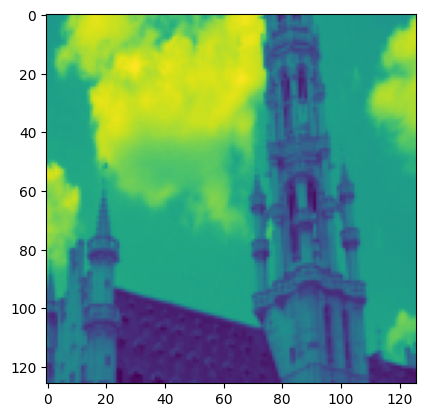

In [ ]:
c,p1,conf = find_densest_square_dbscan(matches,confidenc)
img = crop_img(dados_amostra[5],c,p1)
plt.imshow(img.permute(1,2,0))

In [ ]:
matrix_conf[5][4]

np.float32(2.2419448)

In [ ]:
p1,p2 ,conf,ang = matrix[4][5]

In [ ]:
p1,p2 ,conf,ang = dual_matching(dados_amostra[4],dados_amostra[5])

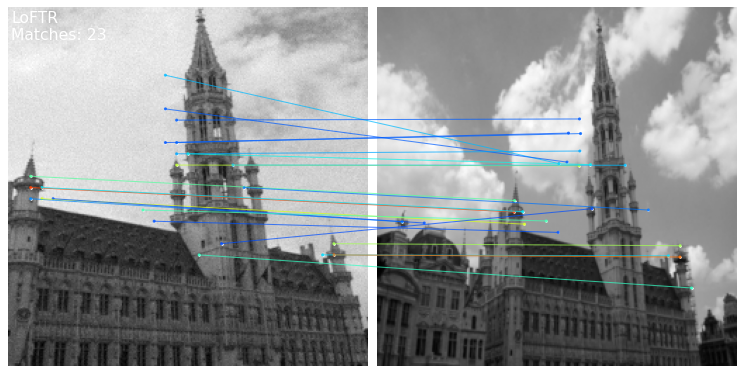

In [ ]:
draw_points(dados_amostra[4],dados_amostra[5],p1,p2,conf)

#Clusterização

#COLMAP

In [ ]:
!pip install pycolmap

In [ ]:
import pycolmap

In [ ]:
!pip install enlighten -q

In [ ]:
"""
An example for running incremental SfM on images with the pycolmap interface.
"""

import shutil
import urllib.request
import zipfile
from pathlib import Path

import enlighten
import pycolmap
from pycolmap import logging


def incremental_mapping_with_pbar(database_path, image_path, sfm_path):
    num_images = pycolmap.Database(database_path).num_images
    with enlighten.Manager() as manager:
        with manager.counter(
            total=num_images, desc="Images registered:"
        ) as pbar:
            pbar.update(0, force=True)
            reconstructions = pycolmap.incremental_mapping(
                database_path,
                image_path,
                sfm_path,
                initial_image_pair_callback=lambda: pbar.update(2),
                next_image_callback=lambda: pbar.update(1),
            )
    return reconstructions


def run():
    output_path = Path("example/")
    image_path = output_path / "Fountain/images"
    database_path = output_path / "database.db"
    sfm_path = output_path / "sfm"

    output_path.mkdir(exist_ok=True)
    # The log filename is postfixed with the execution timestamp.
    logging.set_log_destination(logging.INFO, output_path / "INFO.log.")

    data_url = "https://cvg-data.inf.ethz.ch/local-feature-evaluation-schoenberger2017/Strecha-Fountain.zip"
    if not image_path.exists():
        logging.info("Downloading the data.")
        zip_path = output_path / "data.zip"
        urllib.request.urlretrieve(data_url, zip_path)
        with zipfile.ZipFile(zip_path, "r") as fid:
            fid.extractall(output_path)
        logging.info(f"Data extracted to {output_path}.")

    if database_path.exists():
        database_path.unlink()
    pycolmap.set_random_seed(0)
    pycolmap.extract_features(database_path, image_path)
    pycolmap.match_exhaustive(database_path)

    if sfm_path.exists():
        shutil.rmtree(sfm_path)
    sfm_path.mkdir(exist_ok=True)

    recs = incremental_mapping_with_pbar(database_path, image_path, sfm_path)
    # alternatively, use:
    # import custom_incremental_pipeline
    # recs = custom_incremental_pipeline.main(
    #     database_path, image_path, sfm_path
    # )
    for idx, rec in recs.items():
        logging.info(f"#{idx} {rec.summary()}")


if __name__ == "__main__":
    run()